In [1]:
import contextily
import geopandas as gpd
import pandas as pd
import numpy as np
import cenpy 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path 
import seaborn
import shapely
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/kendallschroth/Downloads/Remissions.csv')
corrs = gpd.GeoDataFrame(df)
corrs.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'index', 'geometry',
       'sqmi', 'state', 'zip_code', '2021 Total GHG Emissions',
       '2018 Total GHG Emissions', 'inc_zips', 'tract_x', 'zip', 'GEOID_x',
       'geometry_x', 'pop_density_2017', 'race_white_2017', 'race_black_2017',
       'asain_white_2017', 'income2017', 'pop_density_2019', 'race_white_2019',
       'race_black_2019', 'asain_white_2019', 'income2019', 'race_total_17',
       'race_total_19', 'pct_white_17', 'pct_black_17', 'pct_asian_17',
       'pct_white_19', 'pct_black_19', 'pct_asian_19', 'inc_dens17',
       'inc_dens19', 'emiss_diff', 'inc_diff', 'inc_dens_diff', 'k5cls'],
      dtype='object')

In [3]:
corrs = corrs.drop(columns = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'index',
       'sqmi', 'state', 'inc_zips', 'tract_x',
       'zip', 'GEOID_x', 'geometry_x', 'pop_density_2017', 'race_white_2017',
       'race_black_2017', 'asain_white_2017',
       'race_white_2019', 'race_black_2019', 'asain_white_2019',
       'race_total_17', 'race_total_19', 'pct_white_17', 'pct_black_17',
       'pct_asian_17',
       'k5cls'])

In [4]:
inc_zips = [94102, 94104, 94130, 94108, 94124, 94133, 94103, 94134, 94132,
 94109, 94112, 94121, 94116, 94111, 94118, 94122, 94115, 94110, 
 94131, 94158, 94114, 94123, 94107, 94117, 94127, 94129, 94105]

tracts = pd.read_csv('/Users/kendallschroth/Downloads/TRACT_ZIP_122021.csv')
tracts = tracts.loc[tracts['zip'].isin(inc_zips)] 
tracts.head(1)

,tract,zip,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio
19945,6075010100,94133,SAN FRANCISCO,CA,1.000000,0.921569,0.978673,0.984426
19946,6075010100,94111,SAN FRANCISCO,CA,0.000000,0.078431,0.021327,0.015574
19947,6075010200,94109,SAN FRANCISCO,CA,0.960412,0.744000,0.948025,0.944763
19948,6075010200,94133,SAN FRANCISCO,CA,0.039588,0.256000,0.051975,0.055237
19949,6075010300,94133,SAN FRANCISCO,CA,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
20288,6075980900,94107,SAN FRANCISCO,CA,0.157918,0.119792,0.465686,0.158967
20290,6075980900,94124,SAN FRANCISCO,CA,0.036745,0.630859,0.411765,0.282414
20662,6081600200,94134,SAN FRANCISCO,CA,0.000000,0.025316,0.000000,0.001576
20663,6081600300,94134,SAN FRANCISCO,CA,0.023697,0.000000,0.050000,0.024012


In [5]:
#cenpy data and vars for 2017
acs = cenpy.products.ACS(2017)
vars_17 = {
    "B19326_001E": "Median Income", #Median Income
    "B08141_016E": "Public Transit Users", #Total population of those who use public transit to commute to work
    "B08141_006E": "Motor Vehicle Users",      #Total population of those who use motor vehicle to commute to work
    "B08137_013E": "Walking Commuters",      #Total population of those who walk to work
    "B08137_019E": "Working From Home",      #Total pop working from home
    "B01003_001E": "Total Pop", #Total pop
}
vars_17_l = list(vars_17.keys())
cen_17 = acs.from_msa("San Francisco, CA",
                  level="tract",
                  variables=vars_17_l
                 )
cen_17 = cen_17.rename(columns=vars_17)

/Users/kendallschroth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/kendallschroth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/kendallschroth/opt/anaconda3/lib/python3.8/site-packages/cenpy/products.py:748: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(


In [6]:
#merging the data set and making readable
cen_17["full_tract"] = '6' + cen_17['county'].astype(str) + cen_17["tract"].astype(str)
cen_17['full_tract'] = cen_17['full_tract'].astype({'full_tract': 'int64'})

merged = tracts.merge(cen_17, how='left', left_on='tract', right_on='full_tract')
merged = merged.drop(labels=['usps_zip_pref_city', 'usps_zip_pref_state',
       'res_ratio', 'bus_ratio', 'oth_ratio', 'tot_ratio', 'full_tract'], axis=1)

merged = corrs.merge(merged, how='left', left_on='zip_code', right_on='zip')
merged.head(1)

,geometry_x,zip_code,2021 Total GHG Emissions,2018 Total GHG Emissions,income2017,pop_density_2019,income2019,pct_white_19,pct_black_19,pct_asian_19,...,Total Pop,Walking Commuters,Working From Home,Motor Vehicle Users,Public Transit Users,Median Income,NAME,state,county,tract_y
0,POLYGON ((-122.4058830019984 37.78571799542011...,94102,22345.3,28414.4,1021.0,1790.0,1078.0,629.0,67.0,869.0,...,1704.0,510.0,60.0,102.0,256.0,30341.0,"Census Tract 117, San Francisco County, Califo...",06,075,011700


In [7]:
merged["total commuters"] = merged["Public Transit Users"] + merged["Motor Vehicle Users"] \
                            + merged["Walking Commuters"] + merged["Working From Home"]

In [8]:
merged["pct_public_transit_users"] = merged["Public Transit Users"] / \
                  (merged["total commuters"] + \
                   (merged["total commuters"]==0) * 1
                  )

merged["pct_motor_vehicle_users"] = merged["Motor Vehicle Users"] / \
                  (merged["total commuters"] + \
                   (merged["total commuters"]==0) * 1
                  )

merged["pct_walking_commuters"] = merged["Walking Commuters"] / \
                  (merged["total commuters"] + \
                   (merged["total commuters"]==0) * 1
                  )

merged["pct_working_from_home"] = merged["Working From Home"] / \
                  (merged["total commuters"] + \
                   (merged["total commuters"]==0) * 1
                  )

merged["total commuters"] = merged["Public Transit Users"] + merged["Motor Vehicle Users"] \
                            + merged["Walking Commuters"] + merged["Working From Home"]
#merged["Population Density"]= merged["Total Pop"]/merged['area']

In [9]:
merged = merged.rename(columns = {'geometry_y':'geometry'})
merged.head(1)

,geometry_x,zip_code,2021 Total GHG Emissions,2018 Total GHG Emissions,income2017,pop_density_2019,income2019,pct_white_19,pct_black_19,pct_asian_19,...,Median Income,NAME,state,county,tract_y,total commuters,pct_public_transit_users,pct_motor_vehicle_users,pct_walking_commuters,pct_working_from_home
0,POLYGON ((-122.4058830019984 37.78571799542011...,94102,22345.3,28414.4,1021.0,1790.0,1078.0,629.0,67.0,869.0,...,30341.0,"Census Tract 117, San Francisco County, Califo...",06,075,011700,928.0,0.275862,0.109914,0.549569,0.064655


In [10]:
groupby = merged.groupby(by=["zip_code"]).mean()

/var/folders/5x/cr898w1d4mx42ptsmgxnnfcm0000gn/T/ipykernel_77636/4028945118.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby = merged.groupby(by=["zip_code"]).mean()


In [11]:
grouped = merged.groupby(by=["zip_code"]).mean()

/var/folders/5x/cr898w1d4mx42ptsmgxnnfcm0000gn/T/ipykernel_77636/901909049.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = merged.groupby(by=["zip_code"]).mean()


In [12]:
from pathlib import Path  
filepath = Path('/Users/kendallschroth/Downloads/grouped.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
grouped.to_csv(filepath)  

In [13]:
merged = gpd.GeoDataFrame(merged)

Text(0.5, 1.0, 'Percent Public Transit Users')

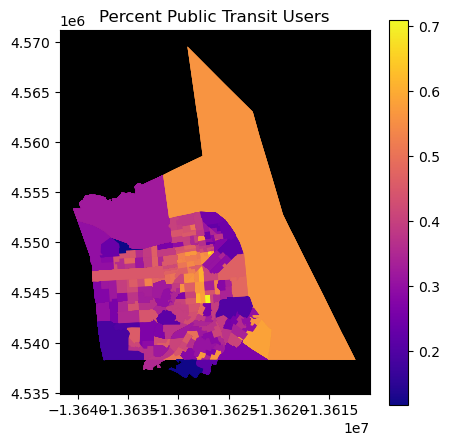

In [14]:
f, ax = plt.subplots(1,1,figsize=(5,5))
merged.dropna(subset=["pct_public_transit_users"], axis=0).plot("pct_public_transit_users", ax=ax, cmap='plasma',legend=True)
ax.set_facecolor('k')
plt.title('Percent Public Transit Users')

Text(0.5, 1.0, 'Percent Motor Vehicle Users')

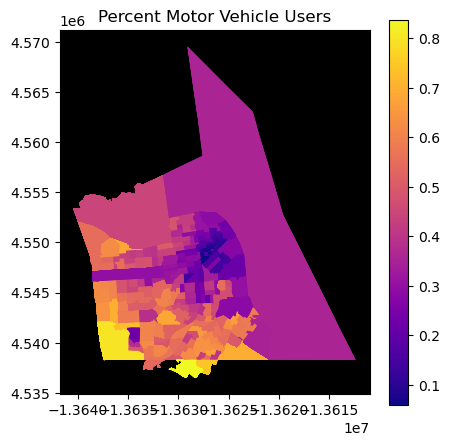

In [15]:
f, ax = plt.subplots(1,1,figsize=(5,5))
merged.dropna(subset=["pct_motor_vehicle_users"], axis=0).plot("pct_motor_vehicle_users", ax=ax, cmap='plasma',legend=True)
ax.set_facecolor('k')
plt.title('Percent Motor Vehicle Users')

Text(0.5, 1.0, 'Percent Walking Commuters')

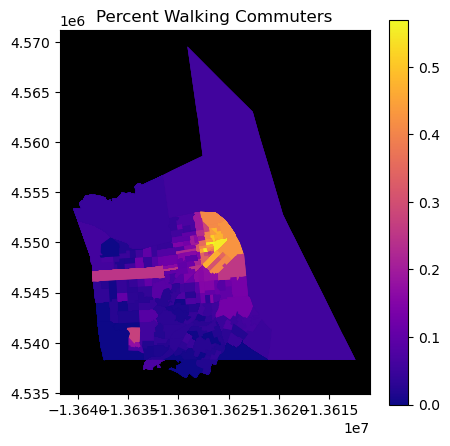

In [16]:
f, ax = plt.subplots(1,1,figsize=(5,5))
merged.dropna(subset=["pct_walking_commuters"], axis=0).plot("pct_walking_commuters", ax=ax, cmap='plasma',legend=True)
ax.set_facecolor('k')
plt.title('Percent Walking Commuters')

Text(0.5, 1.0, 'Percent Working From Home')

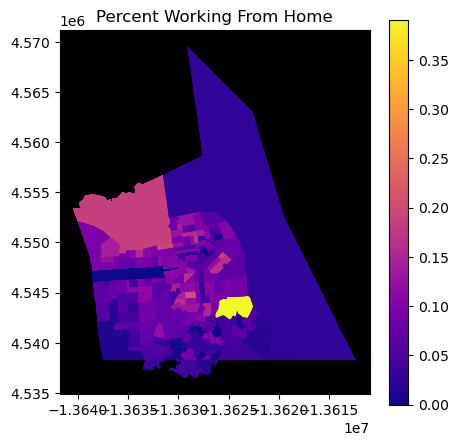

In [17]:
f, ax = plt.subplots(1,1,figsize=(5,5))
merged.dropna(subset=["pct_working_from_home"], axis=0).plot("pct_working_from_home", ax=ax, cmap='plasma',legend=True)
ax.set_facecolor('k')
plt.title('Percent Working From Home')